In [1]:
import numpy as np
import awkward as ak
from coffea.nanoaod import NanoEvents
from uproot_methods import TLorentzVectorArray
import time
from uproot_methods import TVector2Array

In [2]:
!ls data/NanoAOD_files/scheme4_nano.root
fname = "data/NanoAOD_files/scheme4_nano.root"

data/NanoAOD_files/scheme4_nano.root


- Read event tree

In [3]:
events = NanoEvents.from_file(fname)

In [4]:
## Met Filter
met_filter_flags = {
     
        '2016': ['goodVertices',
                 'globalSuperTightHalo2016Filter',
                 'HBHENoiseFilter',
                 'HBHENoiseIsoFilter',
                 'EcalDeadCellTriggerPrimitiveFilter',
                 'BadPFMuonFilter'
             ],

        '2017': ['goodVertices',
                 'globalSuperTightHalo2016Filter',
                 'HBHENoiseFilter',
                 'HBHENoiseIsoFilter',
                 'EcalDeadCellTriggerPrimitiveFilter',
                 'BadPFMuonFilter',
                 'ecalBadCalibFilterV2'
             ],

        '2018': ['goodVertices',
                 'globalSuperTightHalo2016Filter',
                 'HBHENoiseFilter',
                 'HBHENoiseIsoFilter',
                 'EcalDeadCellTriggerPrimitiveFilter',
                 'BadPFMuonFilter',
                 'ecalBadCalibFilterV2'
             ]
    }


In [5]:
## Triggers

met_triggers = {
            '2016': [
                'PFMETNoMu90_PFMHTNoMu90_IDTight',
                'PFMETNoMu100_PFMHTNoMu100_IDTight',
                'PFMETNoMu110_PFMHTNoMu110_IDTight',
                'PFMETNoMu120_PFMHTNoMu120_IDTight'
            ],
            '2017': [
                'PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60',
                'PFMETNoMu120_PFMHTNoMu120_IDTight'
            ],
            '2018': [
                'PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60',
                'PFMETNoMu120_PFMHTNoMu120_IDTight'
            ]
        }

singlephoton_triggers = {
            '2016': [
                'Photon175',
                'Photon165_HE10'
            ],
            '2017': [
                'Photon200'
            ],
            '2018': [
                'Photon200'
            ]
        }

singleelectron_triggers = { #2017 and 2018 from monojet, applying dedicated trigger weights
            '2016': [
                'Ele27_WPTight_Gsf',
                'Ele105_CaloIdVT_GsfTrkIdT'
            ],
            '2017': [
                'Ele35_WPTight_Gsf',
                'Ele115_CaloIdVT_GsfTrkIdT',
                'Photon200'
            ],
            '2018': [
                'Ele32_WPTight_Gsf',
                'Ele115_CaloIdVT_GsfTrkIdT',
                'Photon200'
            ]
        }

In [6]:
print("Total {0} number of events".format(events.shape[0]))

Total 17150 number of events


In [7]:
## met filter
year='2018'
is_met_filter=True
if not is_met_filter:
    met_filters =  np.ones(events.size, dtype=np.bool)
else:
    met_filters =  np.ones(events.size, dtype=np.bool)
    for flag in met_filter_flags[year]:
        if flag not in events.Flag.columns: continue
        met_filters = met_filters & events.Flag[flag]
print(met_filters,met_filters.shape)

[ True  True  True ...  True  True  True] (17150,)


In [8]:
## met trigger

is_met_trigger=False
if not is_met_trigger:
    met_triggers_arr=np.ones(events.size, dtype=np.bool)
else:
    met_triggers_arr = np.zeros(events.size, dtype=np.bool)
    for path in met_triggers[year]:
        if path not in events.HLT.columns: continue
        met_triggers_arr = met_triggers_arr | events.HLT[path]

print(met_triggers_arr,met_triggers_arr.shape)

[ True  True  True ...  True  True  True] (17150,)


In [9]:
## single lepton trigger

is_ele_trigger=False
if not is_ele_trigger:
    ele_triggers_arr=np.ones(events.size, dtype=np.bool)
else:
    ele_triggers_arr = np.zeros(events.size, dtype=np.bool)
    for path in singleelectron_triggers[year]:
        if path not in events.HLT.columns: continue
        ele_triggers_arr = ele_triggers_arr | events.HLT[path]
print(ele_triggers_arr,ele_triggers_arr.shape)

[ True  True  True ...  True  True  True] (17150,)


In [10]:
## single photon trigger

is_pho_trigger=False
if not is_pho_trigger:
    pho_triggers_arr=np.ones(events.size, dtype=np.bool)
else:
    pho_triggers_arr = np.zeros(events.size, dtype=np.bool)
    for path in singlephoton_triggers[year]:
        if path not in events.HLT.columns: continue
        pho_triggers_arr = pho_triggers_arr | events.HLT[path]
print(pho_triggers_arr,pho_triggers_arr.shape)

[ True  True  True ...  True  True  True] (17150,)


In [11]:
events = events[met_filters & met_triggers_arr & ele_triggers_arr & pho_triggers_arr]
print("Total {0} number of events are remain after triggger".format(events.shape[0]))

Total 17088 number of events are remain after triggger


 - Particle branch to array

In [12]:
Electron = events.Electron
Muon = events.Muon
Photon = events.Photon
MET = events.MET

 ### Particle Selection
 - MET > 20 GeV
 - PT$_{e,\gamma}$ > 20 GeV,  |$\eta_{l,\gamma}$| < 2.5,
 - Electron cutbased_id > 1 ( Loose )
 - Photon cutbased_id > 0 ( Loose )

#### How to apply cut in array-based method: Mask  
arr1 = [1,1,2,1]  
arr1_cut_mask = arr1 > 1  
> [ False, False, True, False ]  
  
Sel_arr1 = arr1[arr1_cut_mask]  
> [ 2 ]  

In [13]:
def Particle_Selection(MET,Electron,Photon):
    MET_mask = MET.pt > 20
    Electron_mask = (Electron.pt >20) & (np.abs(Electron.eta) < 2.5) & (Electron.cutBased > 1) 
    #Photon_mask = (Photon.pt > 20 ) & (np.abs(Photon.eta) < 2.5)  & (Photon.genPartFlav == 1) & (Photon.cutBasedBitmap > 0)
    
    Photon_mask = (Photon.pt > 20 ) & (np.abs(Photon.eta) < 2.5)  & (Photon.cutBasedBitmap > 0)
    return(MET_mask,Electron_mask,Photon_mask)

In [14]:
MET_mask,Electron_mask,Photon_mask = Particle_Selection(MET,Electron,Photon)

In [15]:
Ele_Sel_mask = Electron[Electron_mask].counts > 2
Pho_Sel_mask = Photon[Photon_mask].counts > 0

Event_mask = Ele_Sel_mask & Pho_Sel_mask 

In [16]:
print(" - Electron Cut Eff: {0} %".format(
    np.sum(Electron_mask.content) /  len(Electron_mask.content) * 100
    ))

print(" - Photon Cut Eff: {0} %".format(
    np.sum(Photon_mask.content) /  len(Photon_mask.content) * 100
    ))

print(" - Event Selection Eff: {0}%  | number of selected events: {1}".format(
    np.sum(Event_mask) /  len(Event_mask) * 100, np.sum(Event_mask)
    ))

 - Electron Cut Eff: 55.175001103411745 %
 - Photon Cut Eff: 62.587950470330114 %
 - Event Selection Eff: 2.1769662921348316%  | number of selected events: 372


### Event Selection

In [17]:
Ele_channel_events = events[Event_mask]

In [18]:
Ele = Ele_channel_events.Electron
Pho = Ele_channel_events.Photon

In [19]:
Ele

<ElectronArray [[<Electron 78> <Electron 79> <Electron 80>] [<Electron 151> <Electron 152> <Electron 153>] [<Electron 259> <Electron 260> <Electron 261>] ... [<Electron 22494> <Electron 22495> <Electron 22496> <Electron 22497>] [<Electron 22637> <Electron 22638> <Electron 22639> <Electron 22640> <Electron 22641>] [<Electron 22689> <Electron 22690> <Electron 22691> <Electron 22692>]] at 0x7fac1d92e850>

 ### Choose OSSF 

In [20]:
# All possible pairs of Electron in each event
#ele_pairs = Ele.distincts()

# TLorentz vector sum of ele_pairs
#diele = ele_pairs.i0+ele_pairs.i1

# Choose different sign pair ( erase same-sign paris using cut mask)
#diffsign_diele =  diele[diele.charge==0]

# choose maximum pt pairs ( choose maximum-PT Electron paris)
#leading_diffsign_diele = diffsign_diele[diffsign_diele.pt.argmax()]

In [21]:
ele_triple = Ele.choose(3)
trieleMask = (ele_triple.counts == 1)

ele_pairs = Ele.choose(2)

def ossf_zmass_check(dileptons):
    return ((dileptons.i0.charge != dileptons.i1.charge) & 
            (np.abs(91.18 - (dileptons.i0 + dileptons.i1).mass) < 15.)).any()


trieleMask = trieleMask & ossf_zmass_check(ele_pairs)

In [22]:
tri_electrons = Ele[trieleMask]

In [23]:
ele_pairs = tri_electrons.choose(2)
diele = ele_pairs.i0+ele_pairs.i1

In [24]:
diffsign_diele =  diele[diele.charge==0]
diffsign_diele

<JaggedArrayMethods [[TLorentzVector(x=60.931, y=-10.353, z=150.04, t=187.43) TLorentzVector(x=50.738, y=-52.596, z=121.22, t=161.19)] [TLorentzVector(x=-18.895, y=20.608, z=94.781, t=240.12) TLorentzVector(x=-46.73, y=-100.55, z=-114.28, t=183.73)] [TLorentzVector(x=-59.219, y=-198.32, z=203.49, t=303.83) TLorentzVector(x=53.59, y=-62.617, z=80.85, t=147.62)] ... [TLorentzVector(x=86.353, y=-37.257, z=-170.56, t=214.41) TLorentzVector(x=-47.583, y=11.517, z=-239.29, t=269.96)] [TLorentzVector(x=54.027, y=-45.726, z=-118.24, t=164.92) TLorentzVector(x=-60.042, y=13.286, z=-260.74, t=293.52)] [TLorentzVector(x=87.708, y=-34.916, z=-167.88, t=212.06) TLorentzVector(x=-42.488, y=16.578, z=-239.11, t=268.76)]] at 0x7fac2c383ca0>

In [39]:
Zmass_window_mask = (np.abs(91.18 - diffsign_diele.mass) < 15)[:,0] & (np.abs(91.18 - diffsign_diele.mass) < 15)[:,1]

In [40]:
Z_ele = diffsign_diele[Zmass_window_mask]

In [41]:
Mee = Z_ele.mass.content ## contet -> Flatten array 

In [46]:
Mee.shape

(40,)

In [42]:
## --- Not now ...
#def delta_r(pair):
#    return pair.i0.delta_r(pair.i1)

#JselE_pair = Jet.cross(Sel_Electron,nested=True)
#dr_JselE_mask = (delta_r(JselE_pair) > 0.3).any()

#JselA_pair = Jet.cross(Sel_Photon,nested=True)
#dr_JselA_mask = (delta_r(JselA_pair)>0.3).any()


#Jet_mask = Jet_basic_mask & dr_JselE_mask & dr_JselA_mask

### Visualization

In [43]:
import mplhep as hep
import matplotlib.pyplot as plt

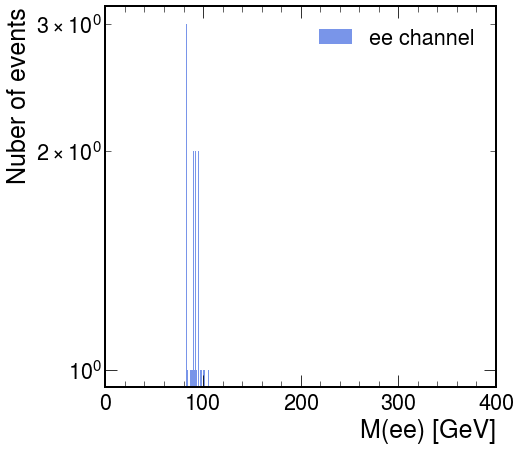

In [44]:
plt.figure(figsize=(7, 7))
plt.style.use(hep.style.CMS)
plt.hist(Mee,bins=50,color='royalblue',alpha=0.7,label='ee channel')
plt.xlim(0,400)
plt.xlabel('M(ee) [GeV]',fontsize=25)
plt.ylabel('Nuber of events',fontsize=25)
plt.yscale('log')
plt.legend()

In [58]:
plt.close

<function matplotlib.pyplot.close(fig=None)>

(0.0, 200.0)

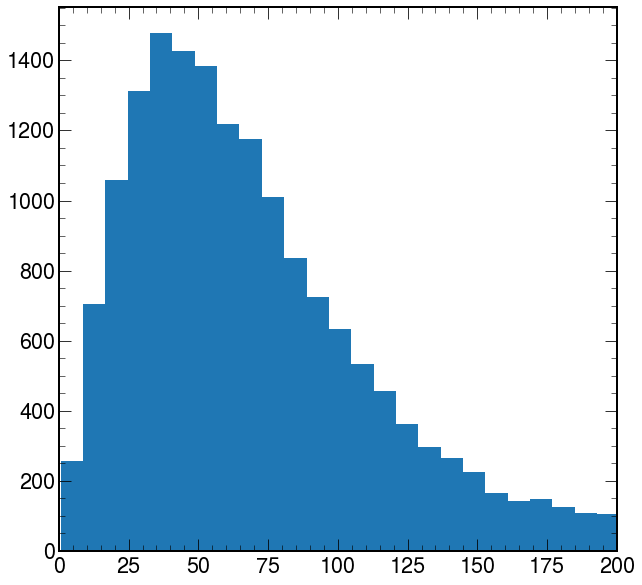

In [62]:
plt.hist(events.MET.pt,bins=100)
plt.xlim([0,200])

(0.0, 200.0)

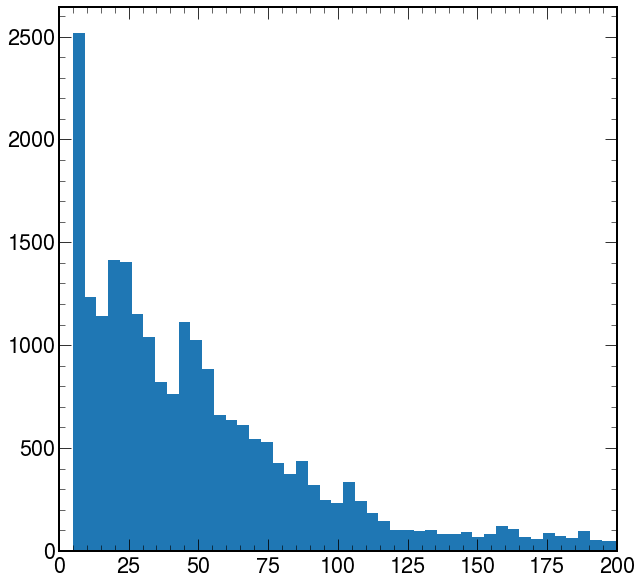

In [71]:
plt.close
plt.hist(Electron.pt.content,bins=200)
plt.xlim([0,200])